# Car Price Prediction — XGBoost + SHAP
**Runtime:** GPU → T4  
**Input:** `cleaned_cars.csv` from Google Drive  
**Outputs:** `car_price_model.pkl` · `shap_data.pkl` · `feature_meta.pkl` · `shap_summary.png`

| Cell | Purpose |
|------|---------|
| **Cell 1** | Feature engineering + time-based train/test split |
| **Cell 2** | XGBoost training (GPU) + evaluation + feature importances |
| **Cell 3** | SHAP analysis + `explain_prediction()` function |

In [1]:
# ── Verify T4 is attached ─────────────────────────────────────────────────────
import subprocess, sys
r = subprocess.run(['nvidia-smi', '--query-gpu=name,memory.total',
                    '--format=csv,noheader'], capture_output=True, text=True)
print('GPU:', r.stdout.strip() if r.returncode == 0 else 'NOT FOUND — switch runtime to T4')

# ── Install / upgrade packages ────────────────────────────────────────────────
!pip install -q xgboost shap joblib scikit-learn pandas numpy matplotlib
print('Packages ready')

GPU: Tesla T4, 15360 MiB
Packages ready


In [2]:
import warnings, os
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib, shap, xgboost as xgb
from pathlib import Path
from sklearn.metrics import mean_absolute_error, mean_squared_error

pd.set_option('display.max_columns', None)
print(f'XGBoost {xgb.__version__} | SHAP {shap.__version__}')

XGBoost 3.2.0 | SHAP 0.50.0


In [3]:
# ── Mount Drive ───────────────────────────────────────────────────────────────
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

CSV_PATH    = '/content/drive/MyDrive/car_data/cleaned_cars.csv'
MODELS_DIR  = Path('/content/drive/MyDrive/car_data/models')
MODELS_DIR.mkdir(parents=True, exist_ok=True)

df = pd.read_csv(CSV_PATH, low_memory=False)
df.columns = df.columns.str.strip().str.lower()
df = df.rename(columns={'manufacturer': 'make'})

print(f'Loaded: {df.shape}  —  columns: {list(df.columns)}')

Mounted at /content/drive
Loaded: (328209, 30)  —  columns: ['id', 'url', 'region', 'region_url', 'price', 'year', 'make', 'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'vin', 'drive', 'size', 'type', 'paint_color', 'image_url', 'description', 'county', 'state', 'lat', 'long', 'posting_date', 'year_month', 'month', 'day_of_week', 'price_per_mile']


---
## Cell 1 — Feature Engineering

In [4]:
LUXURY_MAKES = {
    'bmw', 'mercedes-benz', 'audi', 'lexus', 'porsche', 'cadillac',
    'lincoln', 'infiniti', 'acura', 'volvo', 'land rover', 'jaguar', 'genesis'
}

# ── Category columns to label-encode ─────────────────────────────────────────
CAT_COLS = ['make', 'model', 'condition', 'fuel', 'transmission',
            'drive', 'type', 'state', 'region', 'paint_color',
            'title_status', 'cylinders']

FEATURE_COLS = [
    'car_age', 'log_odometer', 'mileage_per_year', 'is_luxury', 'month',
    'make', 'model', 'condition', 'fuel', 'transmission', 'drive',
    'type', 'state', 'region', 'paint_color', 'title_status', 'cylinders',
    'lat', 'long',
]

def engineer(df: pd.DataFrame, cat_codes: dict = None):
    """Build features. Pass cat_codes=None at train time (fits codes).
    Pass saved cat_codes dict at inference time (maps unseen → -1)."""
    d = df.copy()

    # ── Numeric features ──────────────────────────────────────────────────────
    d['year']       = pd.to_numeric(d['year'],      errors='coerce')
    d['odometer']   = pd.to_numeric(d['odometer'],  errors='coerce')
    d['lat']        = pd.to_numeric(d['lat'],        errors='coerce')
    d['long']       = pd.to_numeric(d['long'],       errors='coerce')

    d['car_age']         = (2024 - d['year']).clip(0, 50).fillna(10)
    d['log_odometer']    = np.log1p(d['odometer'].fillna(0))
    d['mileage_per_year']= d['odometer'].fillna(0) / d['car_age'].replace(0, 1)
    d['is_luxury']       = d['make'].str.lower().isin(LUXURY_MAKES).astype(int)

    # month already exists from cleaning notebook; fallback parse if missing
    if 'month' not in d.columns or d['month'].isna().all():
        d['posting_date'] = pd.to_datetime(d.get('posting_date'), errors='coerce', utc=True)
        d['month'] = d['posting_date'].dt.month.fillna(6)
    d['month'] = d['month'].fillna(6).astype(int)

    # ── Fill geo nulls with median ────────────────────────────────────────────
    d['lat']  = d['lat'].fillna(d['lat'].median())
    d['long'] = d['long'].fillna(d['long'].median())

    # ── Categorical encoding ──────────────────────────────────────────────────
    fitted_codes = {} if cat_codes is None else cat_codes
    for col in CAT_COLS:
        if col not in d.columns:
            d[col] = -1
            continue
        d[col] = d[col].fillna('unknown').astype(str).str.lower().str.strip()
        if cat_codes is None:
            # Training: fit label codes
            d[col] = d[col].astype('category')
            fitted_codes[col] = dict(enumerate(d[col].cat.categories))
            fitted_codes[col] = {v: k for k, v in fitted_codes[col].items()}
            d[col] = d[col].cat.codes
        else:
            # Inference: map known, unknown → -1
            d[col] = d[col].map(cat_codes.get(col, {})).fillna(-1).astype(int)

    available = [c for c in FEATURE_COLS if c in d.columns]
    return d[available], available, fitted_codes


# ── Target: log1p(price) ──────────────────────────────────────────────────────
df = df.dropna(subset=['price'])
df = df[df['price'] > 0]
y_raw = df['price'].values
y_log = np.log1p(y_raw)

# ── Time-based split (sort by posting_date — avoids data leakage) ─────────────
df['posting_date'] = pd.to_datetime(df.get('posting_date'), errors='coerce', utc=True)
df = df.sort_values('posting_date').reset_index(drop=True)

split_idx = int(len(df) * 0.80)
train_df, test_df = df.iloc[:split_idx], df.iloc[split_idx:]
y_train_log = np.log1p(train_df['price'].values)
y_test_log  = np.log1p(test_df['price'].values)

print(f'Train: {len(train_df):,}  |  Test: {len(test_df):,}')
print(f'Train date range: {train_df["posting_date"].min()} → {train_df["posting_date"].max()}')
print(f'Test  date range: {test_df["posting_date"].min()}  → {test_df["posting_date"].max()}')

# ── Build feature matrices ────────────────────────────────────────────────────
X_train, feature_names, cat_codes = engineer(train_df)
X_test,  _,            _          = engineer(test_df, cat_codes)

print(f'\nFeatures ({len(feature_names)}): {feature_names}')
print(f'X_train: {X_train.shape}  |  X_test: {X_test.shape}')

Train: 262,567  |  Test: 65,642
Train date range: 2021-04-04 07:00:25+00:00 → 2021-05-02 00:38:01+00:00
Test  date range: 2021-05-02 00:38:12+00:00  → 2021-05-05 04:24:09+00:00

Features (19): ['car_age', 'log_odometer', 'mileage_per_year', 'is_luxury', 'month', 'make', 'model', 'condition', 'fuel', 'transmission', 'drive', 'type', 'state', 'region', 'paint_color', 'title_status', 'cylinders', 'lat', 'long']
X_train: (262567, 19)  |  X_test: (65642, 19)


---
## Cell 2 — XGBoost Training (T4 GPU)

In [5]:
# ── Auto-detect GPU param style (XGBoost >= 2.0 vs older) ────────────────────
xgb_major = int(xgb.__version__.split('.')[0])
gpu_params = {'device': 'cuda'} if xgb_major >= 2 else {'tree_method': 'gpu_hist'}
print(f'XGBoost {xgb.__version__} — using GPU params: {gpu_params}')

model = xgb.XGBRegressor(
    n_estimators        = 500,
    learning_rate       = 0.05,
    max_depth           = 6,
    subsample           = 0.8,
    colsample_bytree    = 0.8,
    early_stopping_rounds = 50,
    eval_metric         = 'rmse',
    random_state        = 42,
    **gpu_params,
)

model.fit(
    X_train, y_train_log,
    eval_set=[(X_test, y_test_log)],
    verbose=50,
)
print(f'\nBest iteration: {model.best_iteration}')

XGBoost 3.2.0 — using GPU params: {'device': 'cuda'}
[0]	validation_0-rmse:0.90976
[50]	validation_0-rmse:0.56004
[100]	validation_0-rmse:0.52175
[150]	validation_0-rmse:0.50430
[200]	validation_0-rmse:0.49278
[250]	validation_0-rmse:0.48447
[300]	validation_0-rmse:0.47731
[350]	validation_0-rmse:0.47194
[400]	validation_0-rmse:0.46698
[450]	validation_0-rmse:0.46272
[499]	validation_0-rmse:0.45888

Best iteration: 499


In [6]:
# ── Evaluate on original price scale ─────────────────────────────────────────
y_pred_log  = model.predict(X_test)
y_pred      = np.expm1(y_pred_log)
y_test_orig = np.expm1(y_test_log)

mae  = mean_absolute_error(y_test_orig, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred))
mape = np.mean(np.abs((y_test_orig - y_pred) / y_test_orig)) * 100

print('=== Test-set metrics (original $ scale) ===')
print(f'  MAE:  ${mae:,.0f}')
print(f'  RMSE: ${rmse:,.0f}')
print(f'  MAPE: {mape:.2f}%')

# ── Top-10 feature importances ────────────────────────────────────────────────
imp = pd.Series(model.feature_importances_, index=feature_names)
print('\n=== Top-10 feature importances (gain) ===')
print(imp.sort_values(ascending=False).head(10).to_string())

# ── Save model + feature meta ─────────────────────────────────────────────────
joblib.dump(model, MODELS_DIR / 'car_price_model.pkl')

feature_meta = {
    'feature_names': feature_names,
    'cat_codes':     cat_codes,
    'luxury_makes':  list(LUXURY_MAKES),
    'lat_median':    float(df['lat'].median()),
    'long_median':   float(df['long'].median()),
}
joblib.dump(feature_meta, MODELS_DIR / 'feature_meta.pkl')
print('\nSaved: car_price_model.pkl  |  feature_meta.pkl')

=== Test-set metrics (original $ scale) ===
  MAE:  $3,649
  RMSE: $6,817
  MAPE: 48.00%

=== Top-10 feature importances (gain) ===
car_age         0.239708
fuel            0.143269
cylinders       0.088089
log_odometer    0.083944
drive           0.082009
is_luxury       0.059398
title_status    0.049843
type            0.036747
condition       0.034012
transmission    0.032851

Saved: car_price_model.pkl  |  feature_meta.pkl


---
## Cell 3 — SHAP Analysis

In [7]:
# ── Sample 500 rows (T4 is overkill here; keep it fast) ──────────────────────
np.random.seed(42)
sample_idx    = np.random.choice(len(X_test), size=min(500, len(X_test)), replace=False)
X_test_sample = X_test.iloc[sample_idx].reset_index(drop=True)

explainer   = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_sample)

print(f'SHAP values shape: {shap_values.shape}')   # (500, n_features)
print('Expected value (log scale):', round(explainer.expected_value, 4),
      f'→ ${np.expm1(explainer.expected_value):,.0f}')

SHAP values shape: (500, 19)
Expected value (log scale): 9.5794 → $14,463


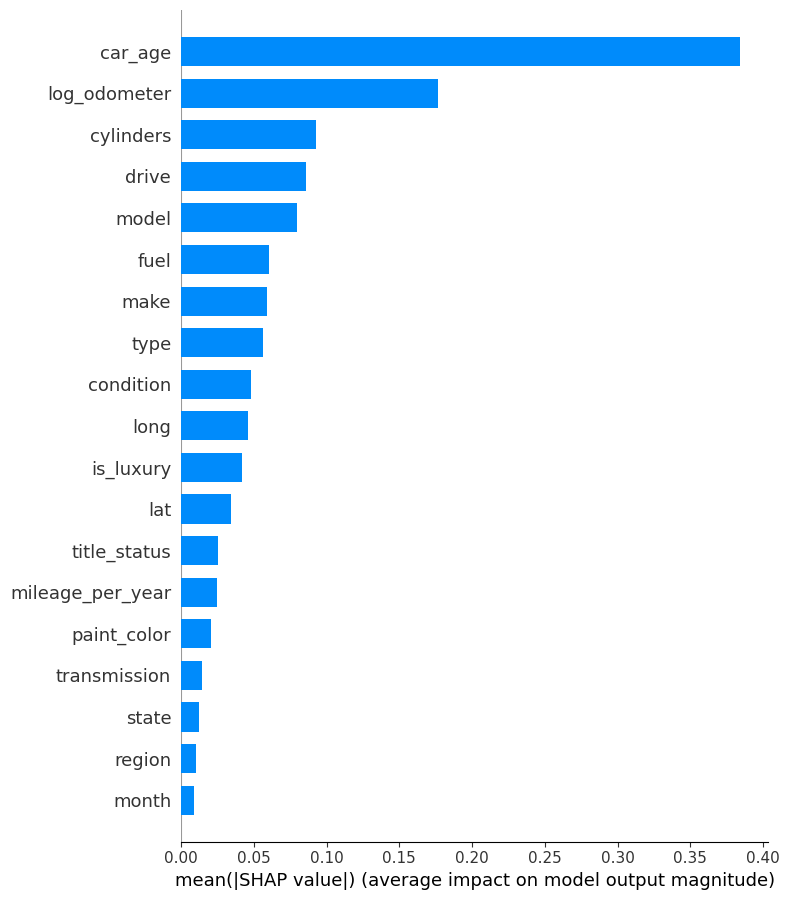

Saved: shap_summary.png


In [8]:
# ── Summary bar plot ─────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(9, 6))
shap.summary_plot(shap_values, X_test_sample,
                  feature_names=feature_names,
                  plot_type='bar', show=False)
plt.tight_layout()
plt.savefig(MODELS_DIR / 'shap_summary.png', dpi=150)
plt.show()
print('Saved: shap_summary.png')

In [9]:
# ── explain_prediction() — will be imported by FastAPI backend ────────────────
def explain_prediction(row_dict: dict) -> list[dict]:
    """
    Given a raw car listing dict (make, year, odometer, …),
    return the top-3 SHAP contributors as:
      [{feature, value, impact, direction}, ...]
    direction is 'increases price' or 'decreases price'.
    """
    row_df = pd.DataFrame([row_dict])
    X_row, _, _ = engineer(row_df, cat_codes)           # use fitted codes from training
    sv = explainer.shap_values(X_row)[0]                # shape: (n_features,)

    top3_idx = np.argsort(np.abs(sv))[::-1][:3]
    return [
        {
            'feature':   feature_names[i],
            'value':     float(X_row.iloc[0, i]),
            'impact':    round(float(abs(sv[i])), 4),
            'direction': 'increases price' if sv[i] > 0 else 'decreases price',
        }
        for i in top3_idx
    ]


# ── Quick sanity test ─────────────────────────────────────────────────────────
sample_row = test_df.iloc[0].to_dict()
explanation = explain_prediction(sample_row)
print('explain_prediction() output:')
for e in explanation:
    print(f"  {e['feature']:20s}  {e['direction']:20s}  impact={e['impact']}")

explain_prediction() output:
  car_age               decreases price       impact=0.8386
  log_odometer          decreases price       impact=0.1347
  type                  decreases price       impact=0.0862


In [10]:
# ── Save SHAP data (explainer + sample) for offline use ──────────────────────
joblib.dump(
    {'explainer': explainer, 'X_test_sample': X_test_sample, 'shap_values': shap_values},
    MODELS_DIR / 'shap_data.pkl'
)
print('Saved: shap_data.pkl')

# ── Download all artefacts to browser ────────────────────────────────────────
from google.colab import files
import shutil, os

LOCAL = Path('/content/model_artefacts')
LOCAL.mkdir(exist_ok=True)

for fname in ['car_price_model.pkl', 'feature_meta.pkl', 'shap_data.pkl', 'shap_summary.png']:
    shutil.copy(MODELS_DIR / fname, LOCAL / fname)
    files.download(str(LOCAL / fname))
    print(f'  Downloaded: {fname}')

Saved: shap_data.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  Downloaded: car_price_model.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  Downloaded: feature_meta.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  Downloaded: shap_data.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  Downloaded: shap_summary.png


In [11]:
print('\n===== Training complete =====')
print(f'  Model:       car_price_model.pkl')
print(f'  Feature meta: feature_meta.pkl  ({len(feature_names)} features)')
print(f'  SHAP data:   shap_data.pkl')
print(f'  SHAP plot:   shap_summary.png')
print(f'\n  MAE  = ${mae:,.0f}')
print(f'  RMSE = ${rmse:,.0f}')
print(f'  MAPE = {mape:.2f}%')
print(f'\n  Copy artefacts to: car-price-intelligence/models/')


===== Training complete =====
  Model:       car_price_model.pkl
  Feature meta: feature_meta.pkl  (19 features)
  SHAP data:   shap_data.pkl
  SHAP plot:   shap_summary.png

  MAE  = $3,649
  RMSE = $6,817
  MAPE = 48.00%

  Copy artefacts to: car-price-intelligence/models/
